In [189]:
import cv2
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from scipy import ndimage, misc

In [190]:
labels = pd.read_csv("labels/save.txt", engine="python")

In [191]:
dic = {}
ppl = []

In [192]:
num = len(labels)

for i in range (num):
    dic[labels["id"][i]] = labels["class"][i]

In [193]:
vals = []

In [194]:
def dispcf(X,Y):
    
    predictions = model.predict(X)
    pred_lbls   = np.argmax(predictions, axis=1)

    true0,false0,true1,false1,true2,false2 = 0,0,0,0,0,0

    for i in range (len(pred_lbls)):
        if pred_lbls[i] == np.argmax(Y[i]):
            if pred_lbls[i] == 0:
                true0 += 1
            elif pred_lbls[i] == 1:
                true1 += 1 
            elif pred_lbls[i] == 2:
                true2 += 1 
        else:
            if pred_lbls[i] == 0:
                false0 += 1
            elif pred_lbls[i] == 1:
                false1 += 1 
            elif pred_lbls[i] == 2:
                false2 += 1 

    print("true0:{}\tfalse0:{}\ntrue1:{}\tfalse1:{}".format(true0,false0,true1,false1)) 
    
    return (1-(true0*false1)/(true1*false0))**2

def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = X[dy:dy*2, :]
    elif dy<0:
        X[dy:, :] = X[dy*2:dy, :]
    if dx>0:
        X[:, :dx] = X[:,dx:dx*2]
    elif dx<0:
        X[:, dx:] = X[:, dx*2:dx]
    return X

In [195]:
x,y = 32,32


for i in dic.keys():
    
    vals.append(dic[i])
    
    img = Image.open("peep/p{:06d}.jpg".format(i))
    width, height = img.size

    left = width/4
    top = 10
    right = 3*width/4
    bottom = height/2
    crp = img.crop((left, top, right, bottom)).resize((x,y))
    
    ppl.append(np.array(crp))

(array([3124.,    0.,    0.,    0.,    0.,  388.,    0.,    0.,    0.,
        3203.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

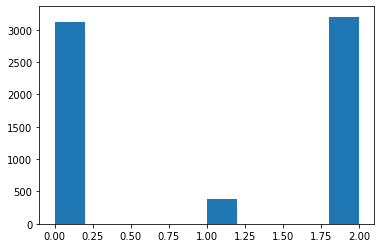

In [196]:
plt.hist(vals)

In [197]:
pred_ppl = []

for j in range(5):
    
    i=j+1
    
    img = Image.open("temp/{:03d}.jpg".format(i))
    width, height = img.size

    left = width/4
    top = 0
    right = 3*width/4
    bottom = height/2
    crp = img.crop((left, top, right, bottom)).resize((x,y))
    
    pred_ppl.append(np.array(crp))
    
pred_ppl = np.array(pred_ppl)

In [198]:
print(len(vals), len(ppl))

6715 6715


In [199]:
for i in range (len(vals)):
    if vals[i]==2:
        vals[i]=0

8.653350515463918


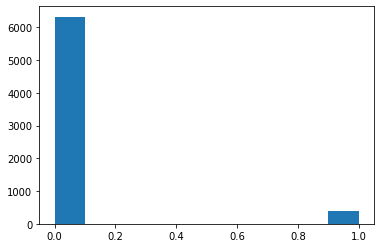

In [200]:
plt.hist(vals)

norm_coeff = (np.average(vals)**-1)/2
print(norm_coeff)

In [201]:
# NORMALIZATION

"""
for i in range (len(vals)):
    if vals[i]==1:
        ppl.append(np.flip(ppl[i], axis=1))
        vals.append(1)
        cv2.imwrite("1s/{:06d}.jpg".format(i), ppl[i])
"""

"""
for i in range (len(vals)):
    if vals[i]==1:
        for j in range(int(1)):
            npl = shift_image(ppl[i],j,j)
            rpl = ndimage.rotate(npl, j, mode="mirror",reshape=False)
            ppl.append(rpl)
            vals.append(1)
"""

'\nfor i in range (len(vals)):\n    if vals[i]==1:\n        for j in range(int(1)):\n            npl = shift_image(ppl[i],j,j)\n            rpl = ndimage.rotate(npl, j, mode="mirror",reshape=False)\n            ppl.append(rpl)\n            vals.append(1)\n'

In [202]:
ppl = np.array(ppl)
vals = np.array(vals)

(array([6327.,    0.,  388.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

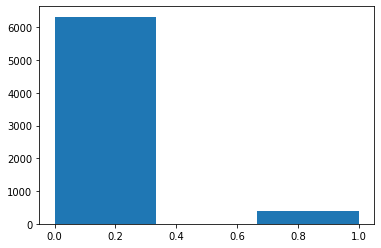

In [203]:
# histogram with twice as much masked people
plt.hist(vals,3)

In [204]:
from sklearn.utils import class_weight
from sklearn.utils import shuffle

ppl, vals = shuffle(ppl, vals)

class_weights = class_weight.compute_class_weight("balanced", np.unique(vals), vals)

In [218]:
class_weight_dict = dict(enumerate(reversed(class_weights)))
class_weight_dict = {0:1 , 1:1}
#class_weight_dict 

In [219]:
# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to calculate accuracy
from sklearn.metrics import accuracy_score

percentage = 70

# loading the dataset
X_train = ppl[:percentage*ppl.shape[0]//100]
X_test  = ppl[percentage*ppl.shape[0]//100:]

y_train = vals[:percentage*ppl.shape[0]//100]
y_test  = vals[percentage*ppl.shape[0]//100:]

# building the input vector from the 28x28 pixels
#X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = len(np.unique(vals))
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (4700,)
Shape after one-hot encoding:  (4700, 2)


In [220]:
"""# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(64, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(x,y,3)))
model.add(Dropout(.2))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(x,y,3)))
model.add(Dropout(.2))
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(48, activation='relu'))
model.add(Dropout(.2))

# output layer
model.add(Dense(2, activation='softmax'))

# compiling the sequential model
model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer='adam')"""

"# building a linear stack of layers with the sequential model\nmodel = Sequential()\n# convolutional layer\nmodel.add(Conv2D(64, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(x,y,3)))\nmodel.add(Dropout(.2))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(x,y,3)))\nmodel.add(Dropout(.2))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\n\n# flatten output of conv\nmodel.add(Flatten())\n# hidden layer\nmodel.add(Dense(48, activation='relu'))\nmodel.add(Dropout(.2))\n\n# output layer\nmodel.add(Dense(2, activation='softmax'))\n\n# compiling the sequential model\nmodel.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer='adam')"

In [ ]:
checkpoint = ModelCheckpoint('modelchkpts/model-{epoch:03d}-{val_binary_accuracy:06f}.h5', verbose=1, monitor='val_binary_accuracy',save_best_only=True, mode='auto')  

log = 100

for i in range(300):
    # training the model for 10 epochs
    model.fit(X_train, Y_train, 
                        batch_size=128, 
                        epochs=1,
                        shuffle=True, 
                        class_weight=class_weight_dict, 
                        callbacks=[checkpoint],
                        validation_data=(X_test, Y_test))
    prs = np.argmax(model.predict(pred_ppl), axis=1)
    print(prs)
    try:
        dispcf(X_test, Y_test)
    except:
        pass 
    
    if np.array_equal(prs,np.array([1,0,0,0,1])):
        print("ANCHOR 10001")
        model.save_weights("models/anchor.h5")
        log = dispcf(X_test, Y_test)

Train on 4700 samples, validate on 2015 samples
Epoch 1/1
4700/4700 [==============================] - 15s 3ms/step - loss: 0.0716 - binary_accuracy: 0.9638 - val_loss: 0.4374 - val_binary_accuracy: 0.9439

Epoch 00001: val_binary_accuracy improved from -inf to 0.94392, saving model to modelchkpts/model-001-0.943921.h5
[0 0 0 0 0]
true0:1895	false0:107
true1:7	false1:6
Train on 4700 samples, validate on 2015 samples
Epoch 1/1
4700/4700 [==============================] - 20s 4ms/step - loss: 0.0476 - binary_accuracy: 0.9772 - val_loss: 0.3527 - val_binary_accuracy: 0.9484

Epoch 00001: val_binary_accuracy improved from 0.94392 to 0.94839, saving model to modelchkpts/model-001-0.948387.h5
[0 0 0 0 0]
true0:1893	false0:96
true1:18	false1:8
Train on 4700 samples, validate on 2015 samples
Epoch 1/1
4700/4700 [==============================] - 16s 3ms/step - loss: 0.0431 - binary_accuracy: 0.9794 - val_loss: 0.4142 - val_binary_accuracy: 0.9479

Epoch 00001: val_binary_accuracy did not impro